# Lab 08 - Model Prediction Speed of Deep Neural Networks

During this lab, we will continue exploring the prediction speed of models. This time we will focus
on deep neural networks.

## 1. Model Serving

We will focus on an object detection task. 

The first task is to select a model from a popular deep learning library, you may use pre-trained
weights to start with, but you should be able to fine-tune the model on a dataset of your choice.
Then, save the model and serve it using NVIDIA Triton Inference Server.


If you prefer, you may use a different dataset of similar size or choose another task of comparable
complexity.

## 2. Measure Inference Speed

We are interested in the performance of the serving setup. Similar to the previous lab, we can use a
general-purpose tool for load testing and benchmarking web services. 

## 3. Experiment with Models and Serving Options

Experiment with different model architectures. In particular, try to prepare several models of
significantly different sizes and compare latency and inference RPS (requests per second) that you
can achieve.

Experiment also with different serving options, such as parallelization, model quantization and protocols
(REST vs. gRPC), etc. Try to draw conclusions from the results. Can you observe any difference in the
inference speed? Does batching influence the results? If possible, provide plots to visualize your
findings. You can obtain raw data from the load-testing tool `Locust` for further analysis \-
https://docs.locust.io/en/stable/retrieving-stats.html#retrieve-test-statistics-in-csv-format.

In [8]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


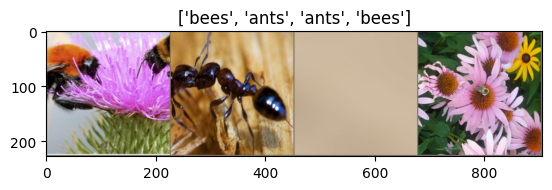

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/sebov/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 52.4MB/s]


In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5669 Acc: 0.7090
val Loss: 0.2471 Acc: 0.9346

Epoch 1/24
----------
train Loss: 0.4759 Acc: 0.7992
val Loss: 0.3254 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.5198 Acc: 0.7869
val Loss: 0.2709 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.5780 Acc: 0.7582
val Loss: 0.2819 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4945 Acc: 0.7910
val Loss: 0.3307 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.3694 Acc: 0.8607
val Loss: 0.3874 Acc: 0.8693

Epoch 6/24
----------
train Loss: 0.4674 Acc: 0.7951
val Loss: 0.4409 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.3506 Acc: 0.8525
val Loss: 0.2413 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3866 Acc: 0.8484
val Loss: 0.2531 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.2998 Acc: 0.8689
val Loss: 0.2501 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.2595 Acc: 0.8893
val Loss: 0.2400 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.2347 Acc: 0.9016
val Loss: 0.2566 Acc: 0.9085

Ep

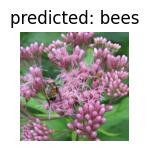

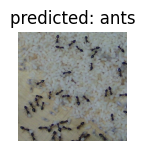

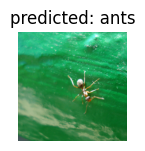

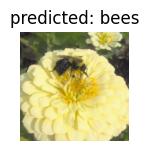

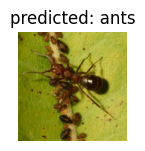

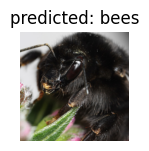

In [21]:
visualize_model(model_ft)

In [22]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [23]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5164 Acc: 0.7172
val Loss: 0.2829 Acc: 0.8758

Epoch 1/24
----------
train Loss: 0.4111 Acc: 0.8156
val Loss: 0.1854 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4267 Acc: 0.8156
val Loss: 0.4211 Acc: 0.8235

Epoch 3/24
----------
train Loss: 0.6230 Acc: 0.7500
val Loss: 0.2346 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.7138 Acc: 0.7049
val Loss: 0.2852 Acc: 0.8824

Epoch 5/24
----------
train Loss: 0.4178 Acc: 0.8238
val Loss: 0.2537 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4755 Acc: 0.7664
val Loss: 0.1578 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3271 Acc: 0.8607
val Loss: 0.1813 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3328 Acc: 0.8443
val Loss: 0.1622 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3320 Acc: 0.8607
val Loss: 0.1632 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3405 Acc: 0.8525
val Loss: 0.1808 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3835 Acc: 0.8279
val Loss: 0.1826 Acc: 0.9477

Ep

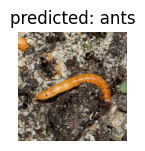

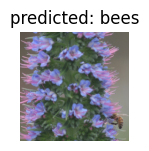

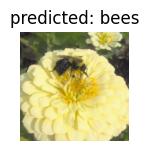

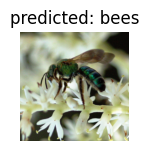

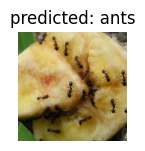

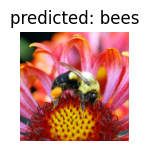

In [24]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [25]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

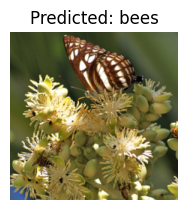

In [26]:
visualize_model_predictions(
    model_conv,
    img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

In [38]:
img_path='data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
img = Image.open(img_path)
img = data_transforms['val'](img)
img = img.unsqueeze(0)
img = img.to(device)

exported = torch.export.export(model_conv, (img,))

torch.export.save(exported, 'resnet18_hymenoptera.pt2')